# Imports


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg

# Load data


In [2]:
baseline = pd.read_csv('baseline.csv')
experiment = pd.read_csv('experiment.csv')

baseline_error = baseline['error_angle_deg'].to_numpy()
experiment_error = experiment['error_angle_deg'].to_numpy()

print('Baseline trials:', len(baseline_error))
print('Experiment trials:', len(experiment_error))

Baseline trials: 160
Experiment trials: 400


# Plot errors with sections


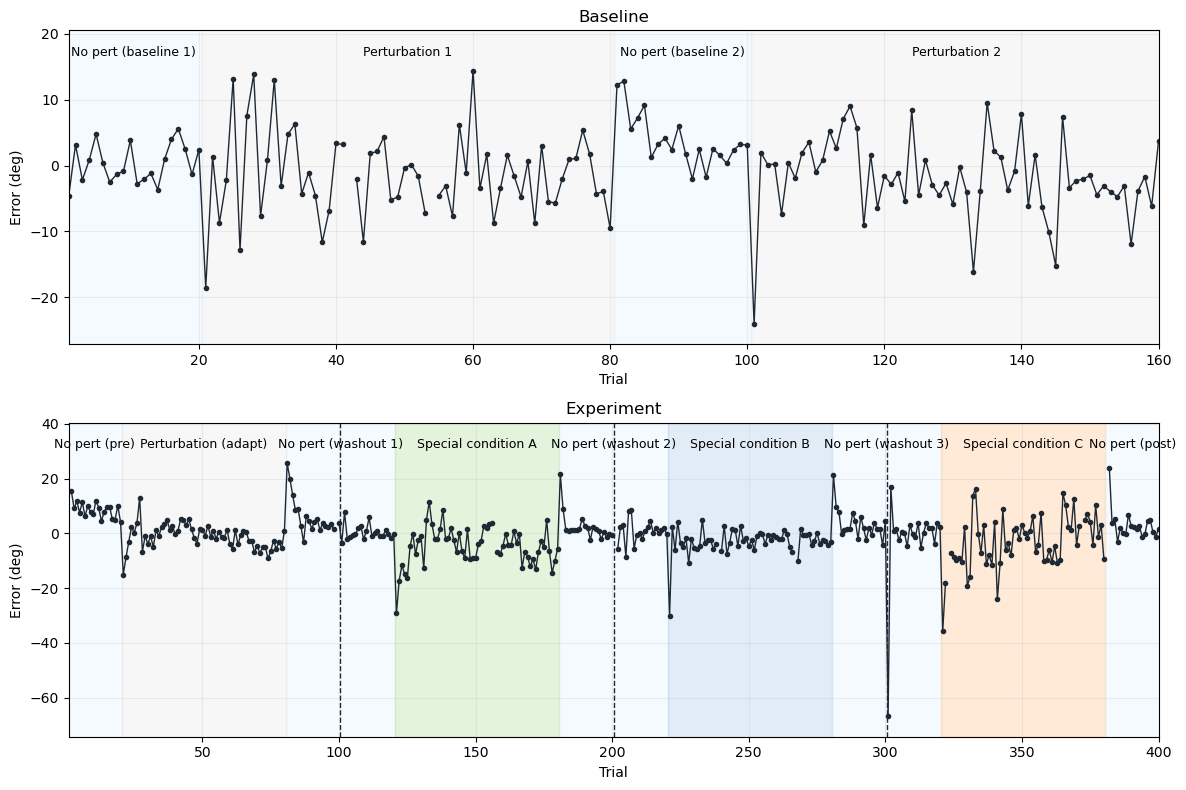

In [3]:
def build_segments(lengths, labels, colors, types):
    segments = []
    start = 1
    for length, label, color, seg_type in zip(lengths, labels, colors, types):
        end = start + length - 1
        segments.append({
            'start': start,
            'end': end,
            'label': label,
            'color': color,
            'type': seg_type,
        })
        start = end + 1
    return segments

def plot_error_with_segments(ax, errors, segments, title, switch_trials=None):
    x = np.arange(1, len(errors) + 1)
    ax.plot(x, errors, marker='o', markersize=3, linewidth=1, color='#1f2933')

    y_min = float(np.nanmin(errors))
    y_max = float(np.nanmax(errors))
    pad = max((y_max - y_min) * 0.08, 1.0)
    label_y = y_max + pad * 0.6

    for seg in segments:
        ax.axvspan(seg['start'] - 0.5, seg['end'] + 0.5, color=seg['color'], alpha=0.2)
        mid = (seg['start'] + seg['end']) / 2
        ax.text(mid, label_y, seg['label'], ha='center', va='bottom', fontsize=9)

    if switch_trials:
        for trial in switch_trials:
            boundary = trial - 0.5
            ax.axvline(boundary, color='#1f2933', linestyle='--', linewidth=1)

    ax.set_xlim(1, len(errors))
    ax.set_ylim(y_min - pad, y_max + pad * 2)
    ax.set_xlabel('Trial')
    ax.set_ylabel('Error (deg)')
    ax.set_title(title)
    ax.grid(True, alpha=0.2)

baseline_segments = build_segments(
    lengths=[20, 60, 20, 60],
    labels=[
        'No pert (baseline 1)',
        'Perturbation 1',
        'No pert (baseline 2)',
        'Perturbation 2',
    ],
    colors=['#cfe8ff', '#d9d9d9', '#cfe8ff', '#d9d9d9'],
    types=['no_pert', 'perturbation', 'no_pert', 'perturbation'],
)

experiment_segments = build_segments(
    lengths=[20, 60, 40, 60, 40, 60, 40, 60, 20],
    labels=[
        'No pert (pre)',
        'Perturbation (adapt)',
        'No pert (washout 1)',
        'Special condition A',
        'No pert (washout 2)',
        'Special condition B',
        'No pert (washout 3)',
        'Special condition C',
        'No pert (post)',
    ],
    colors=[
        '#cfe8ff',
        '#d9d9d9',
        '#cfe8ff',
        '#78c850',
        '#cfe8ff',
        '#6fa3d8',
        '#cfe8ff',
        '#ff9a3c',
        '#cfe8ff',
    ],
    types=[
        'no_pert',
        'perturbation',
        'no_pert',
        'special',
        'no_pert',
        'special',
        'no_pert',
        'special',
        'no_pert',
    ],
)

target_switch_trials = [101, 201, 301]

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)
plot_error_with_segments(axes[0], baseline_error, baseline_segments, 'Baseline')
plot_error_with_segments(axes[1], experiment_error, experiment_segments, 'Experiment', target_switch_trials)
plt.tight_layout()


# After-effect analysis and baseline variability


In [4]:
baseline_no_pert = []
for seg in baseline_segments:
    if seg['type'] == 'no_pert':
        start_idx = seg['start'] - 1
        end_idx = seg['end']
        baseline_no_pert.append(baseline_error[start_idx:end_idx])
baseline_no_pert = np.concatenate(baseline_no_pert)
baseline_motor_variability = float(np.nanstd(baseline_no_pert, ddof=1))

print('Baseline motor variability (std of no-pert trials):', round(baseline_motor_variability, 3))
display(pd.DataFrame({
    'baseline_motor_variability_std': [baseline_motor_variability]
}))


Baseline motor variability (std of no-pert trials): 3.927


,baseline_motor_variability_std
0,3.926999


# Learning after 30 mins

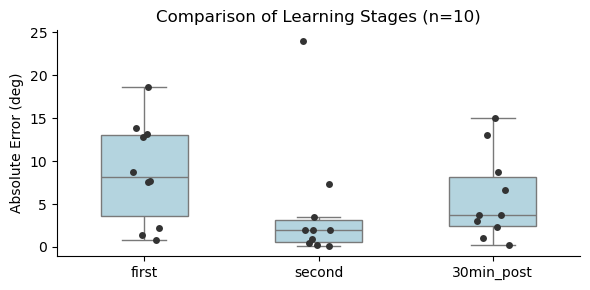

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,condition,30min_post,first,False,False,38.0,two-sided,0.384673,0.384673,holm,-0.506629
1,condition,30min_post,second,False,False,70.0,two-sided,0.140465,0.280930,holm,0.228650
2,condition,first,second,False,False,77.0,two-sided,0.045155,0.135464,holm,0.635747


In [34]:
# Configuration: Define your comparison groups here
n_after = 10
targets = {
    # Label : (Source Array, Start Trial Number)
    "first": (baseline_error, 21),
    "second": (baseline_error, 101),
    "30min_post": (experiment_error, 21)
}

# --- 2. DATA EXTRACTION ---
rows = []
for label, (data_source, start_trial) in targets.items():
    # Convert 1-based trial number to 0-based index
    start_idx = start_trial - 1
    end_idx = min(start_idx + n_after, len(data_source))
    
    window_data = data_source[start_idx:end_idx]
    
    for val in window_data:
        rows.append({
            'condition': label,
            'abs_error': float(np.abs(val))
        })

df_comp = pd.DataFrame(rows)

# --- 3. PLOTTING ---
# Ensure plotting order matches your list, not alphabetical
order = ["first", "second", "30min_post"]

fig, ax = plt.subplots(figsize=(6, 3))

# Boxplot for distribution shape
sns.boxplot(data=df_comp, x='condition', y='abs_error', order=order,
            color='lightblue', width=0.5, ax=ax, showfliers=False)

# Stripplot for raw data transparency (Essential for small N)
sns.stripplot(data=df_comp, x='condition', y='abs_error', order=order,
              color='.2', size=5, jitter=True, ax=ax)

ax.set_ylabel('Absolute Error (deg)')
ax.set_xlabel('')
ax.set_title(f'Comparison of Learning Stages (n={n_after})')
sns.despine() # Makes it look more "scientific publication" style
plt.tight_layout()
plt.show()

# --- 4. STATISTICS ---
stats = pg.pairwise_tests(
    data=df_comp, 
    dv='abs_error', 
    between='condition', 
    padjust='holm',
    parametric=False, # Mann-Whitney U
)

stats

# Generalization plot across target directions


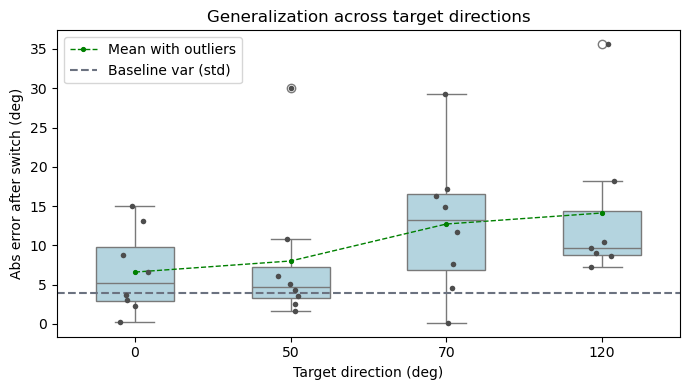

,0,1,2,3,4,5
Contrast,target_angle_deg,target_angle_deg,target_angle_deg,target_angle_deg,target_angle_deg,target_angle_deg
A,0,0,0,50,50,70
B,50,70,120,70,120,120
Paired,False,False,False,False,False,False
Parametric,False,False,False,False,False,False
U-val,32.0,18.0,12.0,19.0,11.0,27.0
alternative,two-sided,two-sided,two-sided,two-sided,two-sided,two-sided
p-unc,1.0,0.160528,0.072106,0.194872,0.054079,0.955089
p-corr,1.0,0.642113,0.360528,0.642113,0.324476,1.0
p-adjust,holm,holm,holm,holm,holm,holm


In [37]:
switch_target_angles = {21: 0, 121: 70, 221: 50, 321: 120}
n_after = 8

# --- 1. DATA COLLECTION (MODIFIED) ---
# We now collect EVERY trial in the window, not just the mean.
rows = []
for switch_trial, angle in switch_target_angles.items():
    start_idx = switch_trial - 1
    end_idx = min(start_idx + n_after, len(experiment_error))
    window = experiment_error[start_idx:end_idx]
    
    # Store individual trials for stats
    for err in window:
        rows.append({
            'target_angle_deg': angle,
            'abs_error': float(np.abs(err)) # Keep absolute error
        })

df_gen = pd.DataFrame(rows).sort_values('target_angle_deg')

# --- 2. PLOTTING ---
fig, ax = plt.subplots(figsize=(7, 4))

# Switched to Boxplot as requested (Standard Seaborn is cleaner than manual plt)
# This replaces your manual ax.plot and handles the grouping automatically
sns.boxplot(data=df_gen, x='target_angle_deg', y='abs_error', color='lightblue', width=0.5, ax=ax)
sns.stripplot(data=df_gen, x='target_angle_deg', y='abs_error', color='.3', size=4, ax=ax) # Adds raw points
sns.pointplot(data=df_gen, x='target_angle_deg', y='abs_error', color='green',
              errorbar=None,
              markersize=3,
              linewidth=1,
              label = "Mean with outliers",
              linestyles='--',
              ax=ax) # add the mean values
ax.axhline(baseline_motor_variability, color='#6b7280', linestyle='--', label='Baseline var (std)')

ax.set_xlabel('Target direction (deg)')
ax.set_ylabel('Abs error after switch (deg)')
ax.set_title('Generalization across target directions')
ax.legend()
plt.tight_layout()
plt.show()

# --- 3. STATISTICS ---
stats = pg.pairwise_tests( #will call mann whitney u test (= Wilcoxon rank-sum test) internally
    data=df_gen, 
    dv='abs_error', 
    between='target_angle_deg', # do not define "within" since we have independent samples
    padjust='holm',
    parametric=False
)

stats.T

# TASK 3 Discussion

#### Q1: Is there any motor adaptation left after 30 minutes?

We can see qualitatively see that there is motor adatpation, even after 30 minutes. The first trail is characterized by a large error, and large variance, while in the second perutrbation both the mean absolute error and motor variablilty have decreased notably. While the error in the last run does is not as low as in the second run, it is still lower than the initial adaptation error. However, none of these observations pass the significance threshold of 5% (stat anal details see below). Still, we assume that with even more data, we would be able to verify adaptation. Especially since we do not end with a washout phase after the baseline run, we would expect the motor system to retain the perturbed internal model and adapt faster on the first run of our experiments. That this retention is not perfect fits with real world limitations and influences, among which forgetting, other hand movements and cognitive strategies are notable.

#### Q2: Under which conditions was your subject able to generalize to new target positions?

Our subject was not able to generalize in statistically significant ways. But leaving this scientific rigor aside, we would indeed observe generalization. The first (left-most) boxplot acts as a reference point of a trained subject. from there on (in temporal order), we observe an increase in absolute error and motor variability (boxplot 3) as the position of the dot changes position. This is to be expected as the subject has not yet had the chance to generalize the strategy for this task. Then, when the new target is in the middle of the two prior points, the generalization is very notable, with abs error and variability being much smaller than in the prior novel target position. This generalization however is not unrestricted, as when the target is very far away from the "learned" locations (boxplot 4), the error is very similar to what we observed before when there was no generalization present in the first place.

# Task 4: statistical analysis

Again, we did statistical analysis to compare the data more rigorously. The results are embedded in the discussions above.
We used the Mann-Whitney U test as the nonparametric alternative to a two-sided t-test, since we do not want to assume normal distribution with only few samples to average. Because of multiple testing, we use the Holm correction method. Since we are only interested in the after-effects, we only consider the first points after phase changes. If we expand the window to obtain the average over longer times, we would see statistically significant results. These are then not clearly attributable to cerebrellar updates of internal models, but could be due to cognitive strategies and other influences.